# 0. Introdução

**Trabalho**:

Aluno: Maicon Dall'Agnol

R.A.: 151161868

Disciplina: Tópico em Aprendizado de Máquina

**Objetivos** :

- Escolha dois datasets rotulados.
- Realize a análise estatística, visualização e pré-processamento dos dados.
-  Realize os experimentos criando duas bases de teste distintas:
- - considerando todos os atributos do dataset;
- - selecionando alguns atributos e descartando outros.
- Aplique três métodos de classificação distintos nas duas bases acima referentes a cada dataset.
- Para cada dataset, em cada uma das bases, analise os resultados segundo medidas de qualidade de classificação, usando índices de validação externa (acurácia, recall, precisão, F-measure, índice Kappa) e cruva ROC.
- Proponha uma maneira adicional de comparar os resultados obtidos além das medidas acima.
- Compare e interprete os resultados dos dois experimentos em cada dataset.
- Faça tabela com as medidas de validação

## 0.1 Dependências

Para realização da tarefa foram utilizados as seguintes bibliotecas:

In [282]:
import pandas as pd
import numpy as np
import pandas_profiling

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# KFold
from sklearn.model_selection import KFold
import random

# Classificadores
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#Metricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from  sklearn.metrics  import  roc_auc_score 
from sklearn.metrics import balanced_accuracy_score

#Visualização
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 1. Dados

Dataset correspondente a fonemas e composto de atributos abstratos cujo atributo alvo é a classe de som nasais ou orais (classe 1 e 2, respectivamente). 

## 1.1 Informações sobre os dados:

#### Atributos:
- V1
- V2
- V2
- V4

#### Classe:
- Class



## Importando Dataset

In [3]:
data_phoneme_raw = pd.read_csv('dados/phoneme.csv')

In [4]:
data_phoneme_raw.head()

,V1,V2,V3,V4,V5,Class
0,0.489927,-0.451528,-1.047990,-0.598693,-0.020418,1
1,-0.641265,0.109245,0.292130,-0.916804,0.240223,1
2,0.870593,-0.459862,0.578159,0.806634,0.835248,1
3,-0.628439,-0.316284,1.934295,-1.427099,-0.136583,1
4,-0.596399,0.015938,2.043206,-1.688448,-0.948127,1


In [5]:
pandas_profiling.ProfileReport(data_phoneme_raw)

Number of variables,6
Number of observations,5404
Total Missing (%),0.0%
Total size in memory,253.4 KiB
Average record size in memory,48.0 B
Numeric,5
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,0


## Visualizações

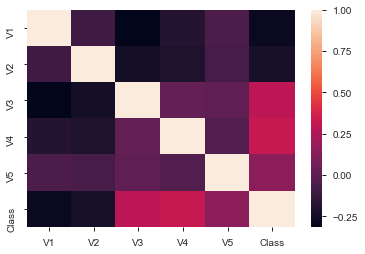

In [302]:
sns.heatmap(data_phoneme_raw.corr())

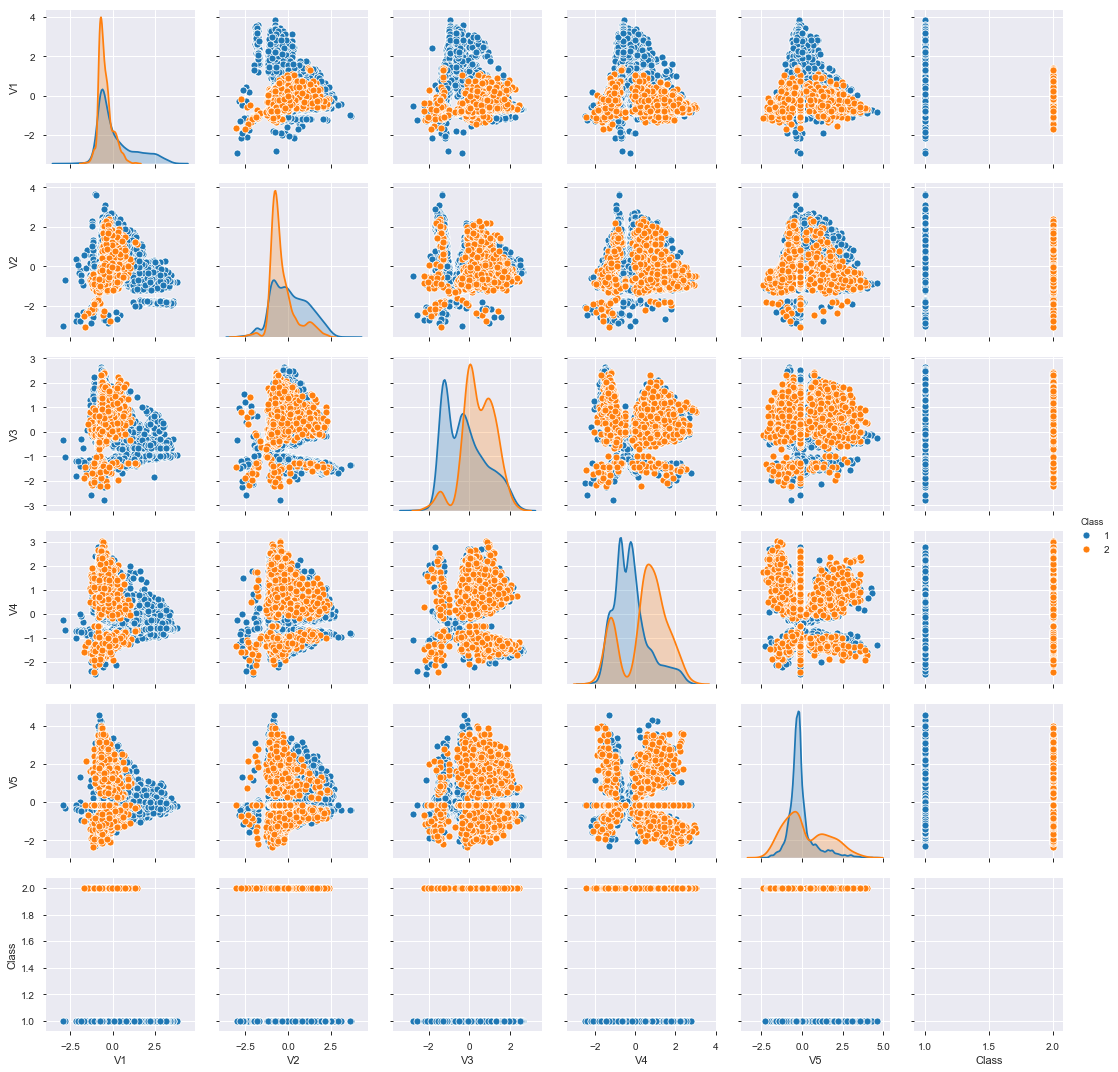

In [303]:
sns.pairplot(data_phoneme_raw, diag_kind="kde",hue='Class')

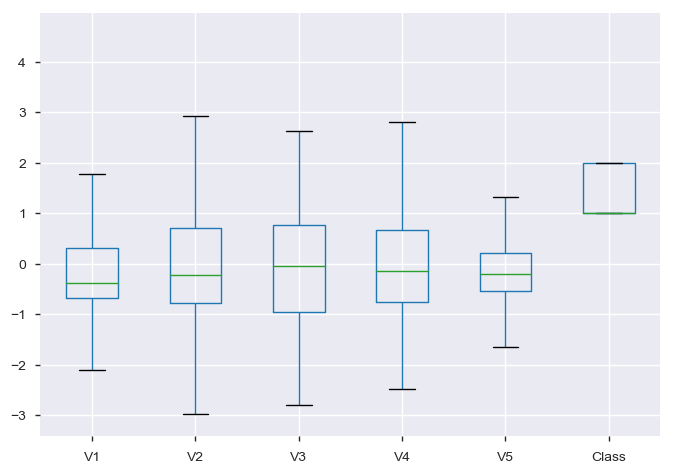

In [103]:
data_phoneme_raw.plot.box()

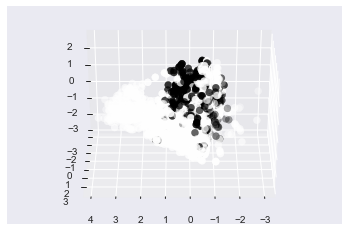

In [304]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_phoneme_raw.V1,data_phoneme_raw.V2, data_phoneme_raw.V3, c=data_phoneme_raw.Class, s=50)
ax.view_init(30, 90)
plt.show()

## PCA

In [374]:
data_pca = PCA(n_components=2).fit_transform(data_phoneme_raw.drop(columns=['Class']))
data_pca = pd.DataFrame(data_pca, columns = ['Var1','Var2'])
data_pca['Class'] = data_phoneme_raw['Class']

In [375]:
data_pca.head()

,Var1,Var2,Class
0,-0.946325,0.652816,1
1,0.083178,-0.725027,1
2,0.530377,1.037576,1
3,0.990195,-0.796042,1
4,0.705725,-1.142581,1


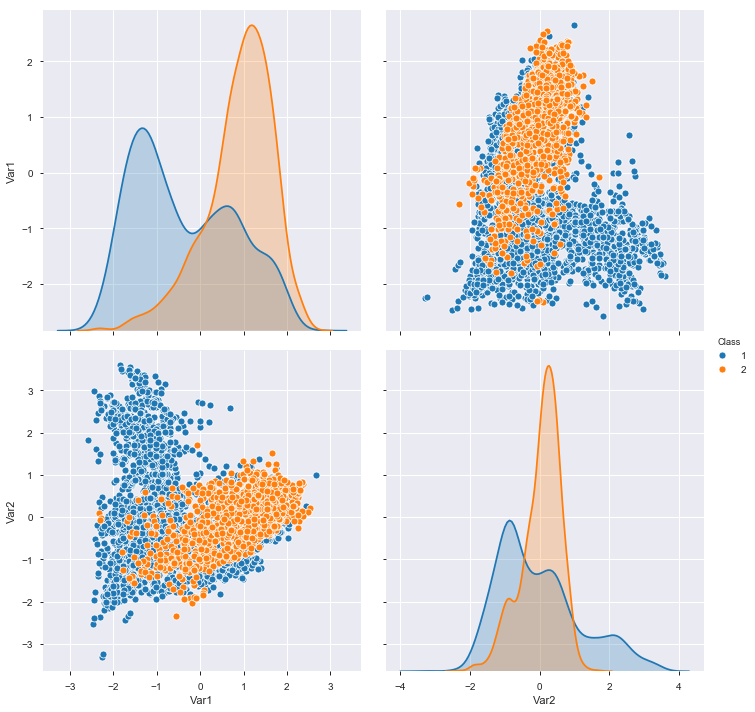

In [376]:
sns.pairplot(data_pca, diag_kind="kde", vars = ['Var1', 'Var2'], hue='Class', size = 5)

## Rebalanceando as Classes com Random under-sampling

In [272]:
count_class_1, count_class_2 = data_phoneme_raw.Class.value_counts()

class_1_df = data_phoneme_raw[data_phoneme_raw['Class'] == 1]
class_2_df = data_phoneme_raw[data_phoneme_raw['Class'] == 2]

In [273]:
print('Class1:', count_class_1)
print('Class2:', count_class_2)

Class1: 3818
Class2: 1586


Random under-sampling:
1    1586
2    1586
Name: Class, dtype: int64


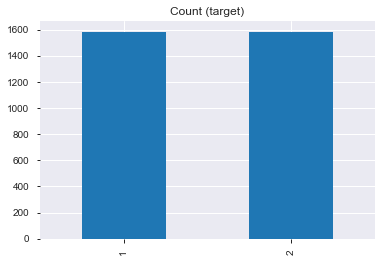

In [337]:
under_class_1_df = class_1_df.sample(count_class_2, random_state=random.randint(2,10))
balanced_df = pd.concat([under_class_1_df, class_2_df], axis=0)

print('Random under-sampling:')
print(balanced_df.Class.value_counts())

balanced_df.Class.value_counts().plot(kind='bar', title='Count (target)');

In [338]:
balanced_df.reset_index(inplace=True, drop=True)

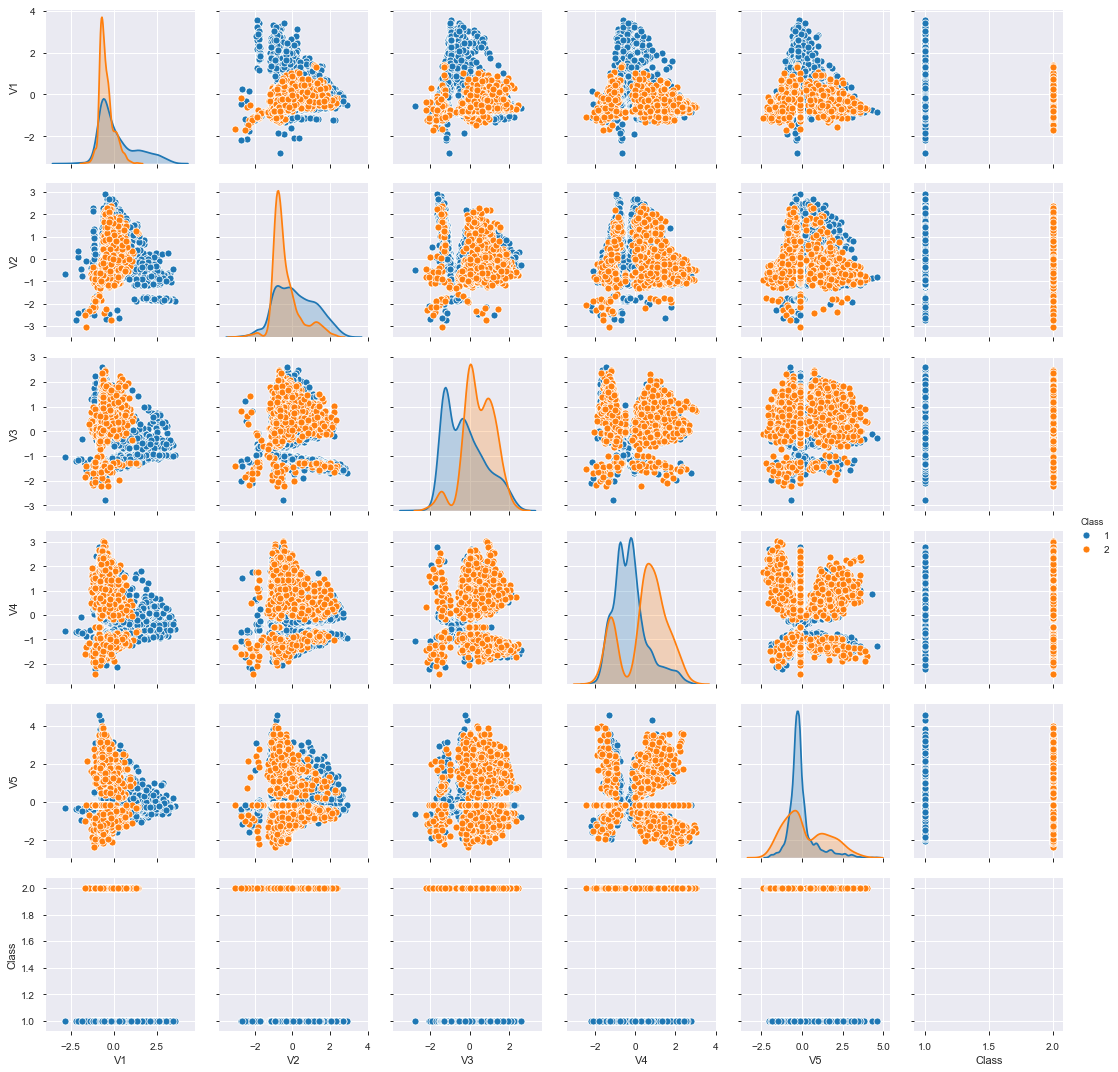

In [339]:
sns.pairplot(balanced_df, diag_kind="kde",hue='Class')

## Classificando

## Funções necessárias

In [430]:
def calcula_metricas(metricas, y_test, y_predict):
    metricas['acc'] += (accuracy_score(y_test, y_predict))
    metricas['recall'] += (recall_score(y_test, y_predict))
    metricas['precision'] += (precision_score(y_test, y_predict))
    metricas['f1'] += f1_score(y_test, y_predict)
    metricas['roc'] += roc_auc_score(y_test, y_predict)
    metricas['kappa'] += cohen_kappa_score(y_test, y_predict)
    metricas['balanced_acc'] += balanced_accuracy_score(y_test, y_predict)

In [431]:
def save_metricas(name, metricas):
    f = open(name, 'w')
    f.write('Acuária:' + str(metricas['acc']) + '\n')
    f.write('Recall:' + str(metricas['recall']) + '\n') 
    f.write('Precisão:' + str(metricas['precision']) + '\n')  
    f.write('F-Measure:' + str(metricas['f1']) + '\n')
    f.write('Curva Roc:' + str(metricas['roc']) + '\n')
    f.write('Indice Kappa:' + str(metricas['kappa']) + '\n')  
    f.write('Acuária Balanceada:' + str(metricas['balanced_acc']) + '\n') 
    f.close()

In [432]:
def show_metricas(metricas):
    print('Acuária:', metricas['acc'])
    print('Recall:', metricas['recall'])
    print('Precisão:', metricas['precision'])
    print('F-Measure:', metricas['f1'])
    print('Curva Roc:', metricas['roc'])
    print('Indice Kappa:', metricas['kappa'])
    print('Acuária Balanceada:', metricas['balanced_acc'])

In [433]:
def write_metricas(name_file, metricas, metodo):  
    f = open(name_file, "a")
    f.write(metodo + ';')
    f.write(str(round(metricas['acc'],4)) + ';')
    f.write(str(round(metricas['recall'],4)) + ';')
    f.write(str(round(metricas['precision'],4)) + ';')
    f.write(str(round(metricas['f1'],4)) + ';')
    f.write(str(round(metricas['roc'],4)) + ';')
    f.write(str(round(metricas['kappa'],4)) + ';')    
    f.write(str(round(metricas['balanced_acc'],4)) + '\n')
    f.close()

## DataFrame Cru

In [456]:
formato = 'Cru'

In [457]:
data_np_x = data_phoneme_raw.drop_duplicates().drop(columns=['Class']).to_numpy()
data_np_y = data_phoneme_raw.drop_duplicates()['Class'].to_numpy()

In [458]:
folds_value = 10

In [459]:
kf = KFold(n_splits=10, shuffle=True, random_state=random.randint(0, 10))
data_kfold = kf.split(data_np_x)

train = []
test = []

for train_index, test_index in data_kfold:
    train.append(train_index)
    test.append(test_index)

In [460]:
name_file = 'metricas-' + formato + '.csv'

f = open(name_file, "w")
f.write(';Acurácia;Recall;Precisão;F1;Roc;Kappa;Acurácia Balanceada\n')
f.close()

## Aplicando KNN com K-fold

In [461]:
metodo = 'KNN'
metricas = {'acc': 0, 'recall': 0, 'precision': 0, 'f1': 0, 'roc': 0, 'kappa': 0, 'balanced_acc': 0}

for train_index, test_index in zip(train, test):
    x_train, x_test = data_np_x[train_index], data_np_x[test_index]
    y_train, y_test = data_np_y[train_index], data_np_y[test_index]

    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(x_train, y_train)

    y_predict = neigh.predict(x_test)

    calcula_metricas(metricas, y_test, y_predict)

for metrica, value in metricas.items():
    metricas[metrica] = value/10

show_metricas(metricas)
write_metricas(name_file, metricas, metodo)

Acuária: 0.9032357589500448
Recall: 0.9448511775439951
Precisão: 0.9204319683648994
F-Measure: 0.932438221179118
Curva Roc: 0.8734025919392348
Indice Kappa: 0.7612078035934119
Acuária Balanceada: 0.8734025919392346


## Aplicando GaussianNB com K-fold

In [462]:
metodo = 'Gauss'
metricas = {'acc': 0, 'recall': 0, 'precision': 0, 'f1': 0, 'roc': 0, 'kappa': 0, 'balanced_acc': 0}

for train_index, test_index in zip(train, test):
    x_train, x_test = data_np_x[train_index], data_np_x[test_index]
    y_train, y_test = data_np_y[train_index], data_np_y[test_index]

    gauss = GaussianNB()
    gauss.fit(x_train, y_train)
    
    y_predict = gauss.predict(x_test)

    calcula_metricas(metricas, y_test, y_predict)

for metrica, value in metricas.items():
    metricas[metrica] = value/10

show_metricas(metricas)
write_metricas(name_file, metricas, metodo)

Acuária: 0.7601587301587303
Recall: 0.7734891686424598
Precisão: 0.8730532145319696
F-Measure: 0.819959951920828
Curva Roc: 0.7502026641758153
Indice Kappa: 0.4635814301249811
Acuária Balanceada: 0.7502026641758153


## Aplicando DecisionTreeClassifier com K-fold

In [463]:
metodo = 'Tree'
metricas = {'acc': 0, 'recall': 0, 'precision': 0, 'f1': 0, 'roc': 0, 'kappa': 0, 'balanced_acc': 0}

for train_index, test_index in zip(train, test):
    x_train, x_test = data_np_x[train_index], data_np_x[test_index]
    y_train, y_test = data_np_y[train_index], data_np_y[test_index]

    tree = DecisionTreeClassifier()
    tree.fit(x_train, y_train)
    
    y_predict = tree.predict(x_test)

    calcula_metricas(metricas, y_test, y_predict)

for metrica, value in metricas.items():
    metricas[metrica] = value/10

show_metricas(metricas)
write_metricas(name_file, metricas, metodo)

Acuária: 0.8711784511784512
Recall: 0.9108228302643171
Precisão: 0.9072069404161821
F-Measure: 0.9089766766727794
Curva Roc: 0.8431826126971625
Indice Kappa: 0.6879177531835117
Acuária Balanceada: 0.8431826126971625


## Aplicando SVM com K-fold

In [464]:
metodo = 'SVM'
metricas = {'acc': 0, 'recall': 0, 'precision': 0, 'f1': 0, 'roc': 0, 'kappa': 0, 'balanced_acc': 0}

for train_index, test_index in zip(train, test):
    x_train, x_test = data_np_x[train_index], data_np_x[test_index]
    y_train, y_test = data_np_y[train_index], data_np_y[test_index]

    svm = SVC()
    svm.fit(x_train, y_train)
    
    y_predict = svm.predict(x_test)

    calcula_metricas(metricas, y_test, y_predict)

for metrica, value in metricas.items():
    metricas[metrica] = value/10

show_metricas(metricas)
write_metricas(name_file, metricas, metodo)


Acuária: 0.8487487116058544
Recall: 0.896382041737635
Precisão: 0.8903387040937798
F-Measure: 0.8932707817698
Curva Roc: 0.814812352136839
Indice Kappa: 0.6326600518433374
Acuária Balanceada: 0.8148123521368389


## DataFrame PCA

In [465]:
formato = 'PCA'

In [466]:
data_np_x = data_pca.drop_duplicates().drop(columns=['Class']).to_numpy()
data_np_y = data_pca.drop_duplicates()['Class'].to_numpy()

In [467]:
folds_value = 10

In [468]:
kf = KFold(n_splits=10, shuffle=True, random_state=random.randint(0, 10))
data_kfold = kf.split(data_np_x)

train = []
test = []

for train_index, test_index in data_kfold:
    train.append(train_index)
    test.append(test_index)

In [469]:
name_file = 'metricas-' + formato + '.csv'

f = open(name_file, "w")
f.write(';Acurácia;Recall;Precisão;F1;Roc;Kappa;Acurácia Balanceada\n')
f.close()

## Aplicando KNN com K-fold

In [470]:
metodo = 'KNN'
metricas = {'acc': 0, 'recall': 0, 'precision': 0, 'f1': 0, 'roc': 0, 'kappa': 0, 'balanced_acc': 0}

for train_index, test_index in zip(train, test):
    x_train, x_test = data_np_x[train_index], data_np_x[test_index]
    y_train, y_test = data_np_y[train_index], data_np_y[test_index]

    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(x_train, y_train)

    y_predict = neigh.predict(x_test)

    calcula_metricas(metricas, y_test, y_predict)

for metrica, value in metricas.items():
    metricas[metrica] = value/10

show_metricas(metricas)
write_metricas(name_file, metricas, metodo)

Acuária: 0.7801735037449323
Recall: 0.8450212951774543
Precisão: 0.8441342541984499
F-Measure: 0.8445076543254452
Curva Roc: 0.7338001421595584
Indice Kappa: 0.46787364047429725
Acuária Balanceada: 0.7338001421595584


## Aplicando GaussianNB com K-fold

In [471]:
metodo = 'Gauss'
metricas = {'acc': 0, 'recall': 0, 'precision': 0, 'f1': 0, 'roc': 0, 'kappa': 0, 'balanced_acc': 0}

for train_index, test_index in zip(train, test):
    x_train, x_test = data_np_x[train_index], data_np_x[test_index]
    y_train, y_test = data_np_y[train_index], data_np_y[test_index]

    gauss = GaussianNB()
    gauss.fit(x_train, y_train)
    
    y_predict = gauss.predict(x_test)

    calcula_metricas(metricas, y_test, y_predict)

for metrica, value in metricas.items():
    metricas[metrica] = value/10

show_metricas(metricas)
write_metricas(name_file, metricas, metodo)

Acuária: 0.7792475778190063
Recall: 0.7870410829301134
Precisão: 0.8881304661780701
F-Measure: 0.8344378906510175
Curva Roc: 0.7731816613604637
Indice Kappa: 0.5057835947623386
Acuária Balanceada: 0.7731816613604637


## Aplicando DecisionTreeClassifier com K-fold

In [472]:
metodo = 'Tree'
metricas = {'acc': 0, 'recall': 0, 'precision': 0, 'f1': 0, 'roc': 0, 'kappa': 0, 'balanced_acc': 0}

for train_index, test_index in zip(train, test):
    x_train, x_test = data_np_x[train_index], data_np_x[test_index]
    y_train, y_test = data_np_y[train_index], data_np_y[test_index]

    tree = DecisionTreeClassifier()
    tree.fit(x_train, y_train)
    
    y_predict = tree.predict(x_test)

    calcula_metricas(metricas, y_test, y_predict)

for metrica, value in metricas.items():
    metricas[metrica] = value/10

show_metricas(metricas)
write_metricas(name_file, metricas, metodo)

Acuária: 0.7755370026798598
Recall: 0.8364393341690827
Precisão: 0.8448544863634206
F-Measure: 0.840492706647386
Curva Roc: 0.7318464461247458
Indice Kappa: 0.4605835521962433
Acuária Balanceada: 0.7318464461247458


## Aplicando SVM com K-fold

In [473]:
metodo = 'SVM'
metricas = {'acc': 0, 'recall': 0, 'precision': 0, 'f1': 0, 'roc': 0, 'kappa': 0, 'balanced_acc': 0}

for train_index, test_index in zip(train, test):
    x_train, x_test = data_np_x[train_index], data_np_x[test_index]
    y_train, y_test = data_np_y[train_index], data_np_y[test_index]

    svm = SVC()
    svm.fit(x_train, y_train)
    
    y_predict = svm.predict(x_test)

    calcula_metricas(metricas, y_test, y_predict)

for metrica, value in metricas.items():
    metricas[metrica] = value/10

show_metricas(metricas)
write_metricas(name_file, metricas, metodo)


Acuária: 0.7951865594722738
Recall: 0.8322422854221699
Precisão: 0.8722890167173055
F-Measure: 0.8516504561170238
Curva Roc: 0.7682771005851456
Indice Kappa: 0.5199464856631275
Acuária Balanceada: 0.7682771005851456


## DataFrame Balanceado

In [474]:
formato = 'Balanceado'

In [475]:
data_np_x = balanced_df.drop_duplicates().drop(columns=['Class']).to_numpy()
data_np_y = balanced_df.drop_duplicates()['Class'].to_numpy()

In [476]:
folds_value = 10

In [477]:
kf = KFold(n_splits=10, shuffle=True, random_state=random.randint(0, 10))
data_kfold = kf.split(data_np_x)

train = []
test = []

for train_index, test_index in data_kfold:
    train.append(train_index)
    test.append(test_index)

In [478]:
name_file = 'metricas-' + formato + '.csv'

f = open(name_file, "w")
f.write(';Acurácia;Recall;Precisão;F1;Roc;Kappa;Acurácia Balanceada\n')
f.close()

## Aplicando KNN com K-fold

In [479]:
metodo = 'KNN'
metricas = {'acc': 0, 'recall': 0, 'precision': 0, 'f1': 0, 'roc': 0, 'kappa': 0, 'balanced_acc': 0}

for train_index, test_index in zip(train, test):
    x_train, x_test = data_np_x[train_index], data_np_x[test_index]
    y_train, y_test = data_np_y[train_index], data_np_y[test_index]

    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(x_train, y_train)

    y_predict = neigh.predict(x_test)

    calcula_metricas(metricas, y_test, y_predict)

for metrica, value in metricas.items():
    metricas[metrica] = value/10

show_metricas(metricas)
write_metricas(name_file, metricas, metodo)

Acuária: 0.8700555045322046
Recall: 0.8684301031357075
Precisão: 0.8720693245828419
F-Measure: 0.8699248356969236
Curva Roc: 0.8701609387223972
Indice Kappa: 0.7395285925502113
Acuária Balanceada: 0.8701609387223972


## Aplicando GaussianNB com K-fold

In [480]:
metodo = 'Gauss'
metricas = {'acc': 0, 'recall': 0, 'precision': 0, 'f1': 0, 'roc': 0, 'kappa': 0, 'balanced_acc': 0}

for train_index, test_index in zip(train, test):
    x_train, x_test = data_np_x[train_index], data_np_x[test_index]
    y_train, y_test = data_np_y[train_index], data_np_y[test_index]

    gauss = GaussianNB()
    gauss.fit(x_train, y_train)
    
    y_predict = gauss.predict(x_test)

    calcula_metricas(metricas, y_test, y_predict)

for metrica, value in metricas.items():
    metricas[metrica] = value/10

show_metricas(metricas)
write_metricas(name_file, metricas, metodo)

Acuária: 0.7442069640218825
Recall: 0.6631589812319786
Precisão: 0.7924692452982228
F-Measure: 0.7212104770648144
Curva Roc: 0.7440491041047028
Indice Kappa: 0.4874987636843975
Acuária Balanceada: 0.7440491041047028


## Aplicando DecisionTreeClassifier com K-fold

In [481]:
metodo = 'Tree'
metricas = {'acc': 0, 'recall': 0, 'precision': 0, 'f1': 0, 'roc': 0, 'kappa': 0, 'balanced_acc': 0}

for train_index, test_index in zip(train, test):
    x_train, x_test = data_np_x[train_index], data_np_x[test_index]
    y_train, y_test = data_np_y[train_index], data_np_y[test_index]

    tree = DecisionTreeClassifier()
    tree.fit(x_train, y_train)
    
    y_predict = tree.predict(x_test)

    calcula_metricas(metricas, y_test, y_predict)

for metrica, value in metricas.items():
    metricas[metrica] = value/10

show_metricas(metricas)
write_metricas(name_file, metricas, metodo)

Acuária: 0.8365431457892425
Recall: 0.8388445212265723
Precisão: 0.837190578980462
F-Measure: 0.8373937923510791
Curva Roc: 0.8363343132041047
Indice Kappa: 0.6721658819534905
Acuária Balanceada: 0.8363343132041047


## Aplicando SVM com K-fold

In [482]:
metodo = 'SVM'
metricas = {'acc': 0, 'recall': 0, 'precision': 0, 'f1': 0, 'roc': 0, 'kappa': 0, 'balanced_acc': 0}

for train_index, test_index in zip(train, test):
    x_train, x_test = data_np_x[train_index], data_np_x[test_index]
    y_train, y_test = data_np_y[train_index], data_np_y[test_index]

    svm = SVC()
    svm.fit(x_train, y_train)
    
    y_predict = svm.predict(x_test)

    calcula_metricas(metricas, y_test, y_predict)

for metrica, value in metricas.items():
    metricas[metrica] = value/10

show_metricas(metricas)
write_metricas(name_file, metricas, metodo)


Acuária: 0.8438046559916945
Recall: 0.7710744526685108
Precisão: 0.9033264871646102
F-Measure: 0.8310090726922817
Curva Roc: 0.8440004071747682
Indice Kappa: 0.6870582735808017
Acuária Balanceada: 0.844000407174768
